In [2]:
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import argparse
import os 
from tqdm import tqdm
import json


In [29]:
class GraphData:
    
    def __init__(self, 
                 file_path: str, 
                 counts_threshold: int, 
                 output_path: str = "./graph_data"):
        
        self.file_path = file_path 
        self.output_path = output_path
        self.counts_threshold = counts_threshold
        
        try:
            os.mkdir(self.output_path)
        except OSError as error:
            raise error

        self.feature_df = self.genes_df()
        
        self.get_edges()

        
    def genes_df(self):
        
        df = pd.read_json('/home/angelosmath/MSc/thesis_genes/bioc_august/test_df_200.json')
        
        # remove papers that refer only 1 gene
        mask_single_gene = df['Genes'].apply(lambda x: len(x) == 1)
        df_filtered = df[~mask_single_gene]

        print("found {} papers that contain pairs of genes".format(df_filtered.shape[0]))
        
        return df_filtered

    def get_edges(self):

        self.pair_counts = {}

        for _, row in tqdm(self.feature_df.iterrows()):
            
            feature = row['Genes']
            pairs = list(itertools.combinations(feature, 2))

            for pair in pairs:
                pair = tuple(sorted(pair))  # Sort to ensure consistency
                if pair in self.pair_counts:
                    self.pair_counts[pair] += 1
                else:
                    self.pair_counts[pair] = 1
        return self.pair_counts
        
    def export(self):
        
        pair_counts_str_keys = {str(pair): count for pair, count in self.pair_counts.items()}
        
        with open(f'{self.output_path}/pairs_dictionary.json', 'w') as json_file:
            json.dump(pair_counts_str_keys, json_file)

        df = pd.DataFrame(list(self.pair_counts.items()), columns=['pair', 'count'])
        df = df.drop_duplicates(subset='pair')
        df[['from', 'to']] = pd.DataFrame(df['pair'].tolist(), index=df.index)
        df.drop(columns=['pair'], inplace=True)
        df['rel'] = 'gene-->gene'
        df = df[['from', 'to', 'rel', 'count']]

        # Download protein-coding gene data
        protein_coding_url = "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/locus_groups/protein-coding_gene.txt"
        protein_coding_file = "protein-coding_gene.txt"
        os.system(f"wget {protein_coding_url} -O {protein_coding_file}") 
        df_protein_coding = pd.read_csv('protein-coding_gene.txt', delimiter='\t', header=0, low_memory=False)

        
        # Filter out rows with 'from' and 'to' genes not in df_protein_coding
        valid_genes = set(df_protein_coding['entrez_id'])
        df = df[df['from'].isin(valid_genes)]
        df = df[df['to'].isin(valid_genes)]
                
        #drop the rows that count is lower or equal to the threshold 
        df = df[df['count'] > self.counts_threshold]

        df.to_json(f'{self.output_path}/graph_df.json', orient='records', lines=False) 
        
        print(f'after the threshold aplied and the genes checked if they involved in protein coding we have {df.shape[0]} pairs')
        print('all files export successfully')

In [ ]:
#!wget https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/locus_groups/protein-coding_gene.txt

In [31]:
a = GraphData(file_path = '/home/angelosmath/MSc/thesis_genes/bioc_august/test_df_200.json' , 
              counts_threshold = 2, 
              output_path = "./graph_data_test")

found 14732 papers that contain pairs of genes


14732it [00:02, 5463.18it/s]


In [32]:
a.export()

--2023-08-26 01:01:39--  https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/locus_groups/protein-coding_gene.txt
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9428809 (9,0M) [text/plain]
Saving to: ‘protein-coding_gene.txt’

     0K .......... .......... .......... .......... ..........  0%  158K 58s
    50K .......... .......... .......... .......... ..........  1%  321K 43s
   100K .......... .......... .......... .......... ..........  1%  323K 38s
   150K .......... .......... .......... .......... ..........  2%  409K 34s
   200K .......... .......... .......... .......... ..........  2%  452K 31s
   250K .......... .......... .......... .......... ..........  3%  383K 29s
   300K .......... .......... .......... .......... ..........  3%  256K 30s
   350K .......... .......... .......... .......... ..........  4%  304K 30s
   400K ..

after the threshold aplied and the genes checked if they involved in protein coding we have 39318 pairs
all files export successfully


In [3]:
df = pd.read_json('/home/angelosmath/MSc/thesis_genes/graph_data/graph_data_test/graph_df.json')

In [4]:
df.shape

(22064, 3)

In [37]:
df

,from,to,rel,count
0,673,4609,gene-->gene,15
1,673,5711,gene-->gene,3
2,673,5366,gene-->gene,3
3,673,5594,gene-->gene,28
4,673,5595,gene-->gene,12
...,...,...,...,...
39313,104,105,gene-->gene,3
39314,351,1351,gene-->gene,3
39315,2185,2950,gene-->gene,3
39316,5609,6898,gene-->gene,3


In [38]:
# Assuming your DataFrame is named 'df'
unique_genes = set(df['from']).union(df['to'])

num_unique_genes = len(unique_genes)
print("Number of unique genes:", num_unique_genes)

Number of unique genes: 2582


In [35]:
count_frequency 

count
2      56818
3      17254
4       7579
5       4084
6       2587
       ...  
127        1
133        1
145        1
67         1
195        1
Name: count, Length: 113, dtype: int64

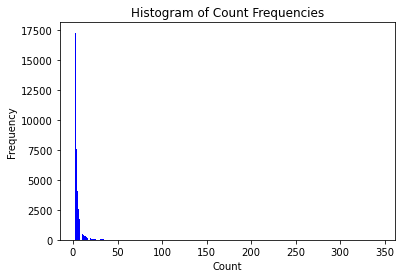

In [36]:


# Calculate the frequency of each count value
count_frequency = df['count'].value_counts()

# Create a histogram for the count frequencies
plt.bar(count_frequency.index, count_frequency.values, color='blue')

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Histogram of Count Frequencies')

# Display the histogram
plt.show()

In [ ]:
df

In [39]:
from torchkge.data_structures import KnowledgeGraph

df_triples = df.drop(columns=['count'])

torchKG = KnowledgeGraph(df=df_triples)



/home/angelosmath/.local/lib/python3.10/site-packages/torchkge/utils/data_redundancy.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [40]:
torchKG

In [ ]:
entrez_ids = list(torchKG.ent2ix.keys())

df_entrez_ids = pd.DataFrame(entrez_ids, columns=['entrez_id'])

in_df = df_entrez_ids.isin(df_protein_coding_entrez_ids['entrez_id'])

print(any(in_df))

In [ ]:
df_protein_coding = pd.read_csv('protein-coding_gene.txt', delimiter='\t', header=0)

In [ ]:
df_protein_coding['entrez_id'][0]

In [ ]:
df_protein_coding

In [ ]:
df = pd.read_json('/home/angelosmath/MSc/thesis_genes/bioc_august/test_df_200.json')


# Count rows with only one element in the 'Genes' set
mask_single_gene = df['Genes'].apply(lambda x: len(x) == 1)

df_filtered = df[~mask_single_gene]

print("found {} papers that refer more than one genes".format(df_filtered.shape[0]))

In [ ]:
        
    def visualize_graph(self):
        G = self.construct_graph()

        # Manually specify node positions for better layout
        pos = nx.spring_layout(G, seed=42)

        # Adjust node separation
        pos = {node: (x, y + 0.1) for node, (x, y) in pos.items()}

        labels = {node: node for node in G.nodes}

        # Draw the graph using NetworkX and Matplotlib
        plt.figure(figsize=(12, 10))
        nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='skyblue', label=True)
        nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')
        nx.draw_networkx_edges(G, pos, width=0.5, edge_color='gray')

        plt.title("Gene Interaction Graph")
        plt.legend()
        plt.show()

    def construct_graph(self):
        
        G = nx.Graph()

        for pair, count in self.pair_counts.items():
            gene1, gene2 = pair
            G.add_edge(gene1, gene2, weight=count)

        return G

In [ ]:
    def visualize_graph(self, visual_path=None):
        
        if visual_path == False:
            return None 
    
        self.graph = self.get_edges()

        # Create a mapping of unique colors for nodes and relations
        node_colors = plt.cm.tab20.colors
        relation_colors = plt.cm.Set1.colors

        node_color_map = {}  
        relation_color_map = {}

        for i, node in enumerate(graph.nodes()):
            node_color_map[node] = node_colors[i % len(node_colors)]

        for i, edge_data in enumerate(graph.edges(data=True)):
            relation = edge_data[2]['relation']
            if relation not in relation_color_map:
                relation_color_map[relation] = relation_colors[i % len(relation_colors)]

        # Visualize the graph
        pos = nx.spring_layout(graph)  # You can choose a different layout if needed
        plt.figure(figsize=(12, 8))

        # Draw nodes with their respective colors
        for node, color in node_color_map.items():
            nx.draw_networkx_nodes(graph, pos, nodelist=[node], node_color=color, node_size=200, label=node)

        # Draw edges with their respective colors
        for relation, color in relation_color_map.items():
            edge_list = [(u, v) for u, v, data in graph.edges(data=True) if data['relation'] == relation]
            nx.draw_networkx_edges(graph, pos, edgelist=edge_list, edge_color=color, width=1.5, label=relation)

        # Draw node labels (optional)
        #labels = {node: node for node in graph.nodes()}
        #nx.draw_networkx_labels(graph, pos, labels, font_size=8)

        plt.legend()
        plt.title("Graph Visualization")
        plt.axis("off")
        plt.savefig(f'{self.output_path}/graph_visualization.pdf', format="pdf")
        plt.close()

Sorting the pairs before storing them in the dictionary helps ensure consistency and prevents duplication of counts for pairs with the same elements but in a different order.

Consider the following example:

Suppose you have two rows with the following 'genes' lists:

    Row 1: ['gene1', 'gene2']
    Row 2: ['gene2', 'gene1']

Without sorting, these two lists would generate two different pairs:

    Pair 1: ('gene1', 'gene2')
    Pair 2: ('gene2', 'gene1')

However, these pairs actually represent the same relationship between 'gene1' and 'gene2'. By sorting the elements within the pairs, you can ensure that they are consistent and represent the same relationship regardless of their original order. So, both lists will generate the same pair:

    Pair: ('gene1', 'gene2')

By doing this, when counting pairs, you don't double-count the same relationship just because the order of genes in the pair is different. Sorting ensures that pairs with the same elements will be stored consistently and avoid any confusion in the counting process.